# Modelar os efeitos dos descontos durante as semanas festivas

## 1. Importando bibliotecas

In [236]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns

## 2. Importando dados unificados

In [198]:
df = pd.read_csv("../data/dados_unificados.csv", decimal=',')

In [199]:
df.columns

Index(['Unnamed: 0', 'Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Year',
       'Month', 'Week', 'DayOfYear', 'DescontoSum', 'TemDesconto',
       'DescontoAvg', 'Dept_encoded', 'Store_encoded', 'Type_encoded',
       'Month_encoded'],
      dtype='object')

In [200]:
df['Date'] = pd.to_datetime(df['Date'])

## 3. Analise

Os dados de descontos estão disponíveis apenas a partir de novembro de 2011 e não para
todas as lojas ou em todos os períodos

### 3.1 Selecionar somente periodo com descontos

In [201]:
len(df)

421570

In [202]:
df = df[df['Date'] >= '2011-11-01']

In [203]:
len(df)

154386

In [204]:
df

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Month,Week,DayOfYear,DescontoSum,TemDesconto,DescontoAvg,Dept_encoded,Store_encoded,Type_encoded,Month_encoded
91,91,1,1,2011-11-04,39886.06,False,54.98,3.332,0.00,0.00,...,11,44,308,0.00,False,0.000,19213.485088,21710.543621,20099.568043,17491.031424
92,92,1,1,2011-11-11,18689.54,False,59.11,3.297,10382.90,6115.67,...,11,45,315,25671.68,True,5134.336,19213.485088,21710.543621,20099.568043,17491.031424
93,93,1,1,2011-11-18,19050.66,False,62.25,3.308,6074.12,254.39,...,11,46,322,12796.45,True,2559.290,19213.485088,21710.543621,20099.568043,17491.031424
94,94,1,1,2011-11-25,20911.25,True,60.14,3.236,410.31,98.00,...,11,47,329,56876.74,True,11375.348,19213.485088,21710.543621,20099.568043,17491.031424
95,95,1,1,2011-12-02,25293.49,False,48.91,3.172,5629.51,68.00,...,12,48,336,29655.58,True,5931.116,19213.485088,21710.543621,20099.568043,19355.702141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,...,9,39,272,9468.01,True,1893.602,6824.694889,11662.897315,12237.075977,15095.886154
421566,421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,0.00,...,10,40,279,9659.00,True,1931.800,6824.694889,11662.897315,12237.075977,15243.855576
421567,421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,0.00,...,10,41,286,6554.03,True,1310.806,6824.694889,11662.897315,12237.075977,15243.855576
421568,421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,0.00,...,10,42,293,3982.42,True,796.484,6824.694889,11662.897315,12237.075977,15243.855576


In [205]:
# Agrupar por loja e somar os descontos
discount_totals = df.groupby('Store')[markdown_cols].sum()

# Filtrar lojas que têm todos os descontos iguais a 0
stores_without_discounts = discount_totals[(discount_totals == 0).all(axis=1)].index.tolist()

# Mostrar o resultado
print("Lojas que nunca aplicaram descontos:", stores_without_discounts)

Lojas que nunca aplicaram descontos: []


In [206]:
holiday_df = df[df['IsHoliday'] == True].copy()

### 3.2 Análise de correlação entre descontos e vendas

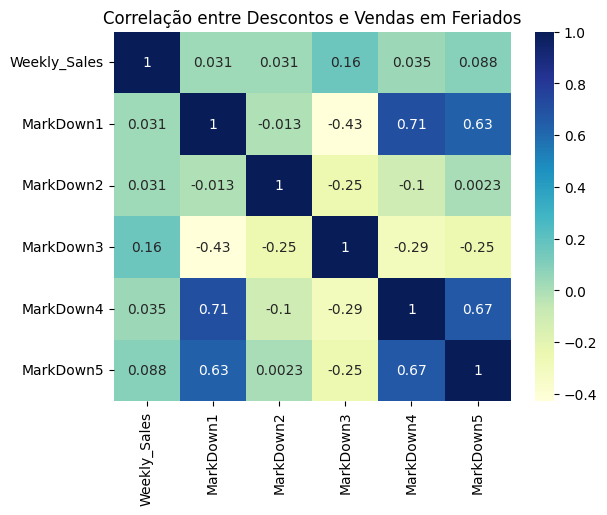

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt

markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
corr_holiday = holiday_df[['Weekly_Sales'] + markdown_cols].corr()

# Plot
sns.heatmap(corr_holiday, annot=True, cmap='YlGnBu')
plt.title('Correlação entre Descontos e Vendas em Feriados')
plt.show()


### 3.3 Análise desconto x feriado x vendas

/var/folders/rb/g2rznbp50d56w_26l6lfc72c0000gn/T/ipykernel_41346/1482812296.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Grupo', y='Weekly_Sales', palette='Set2')


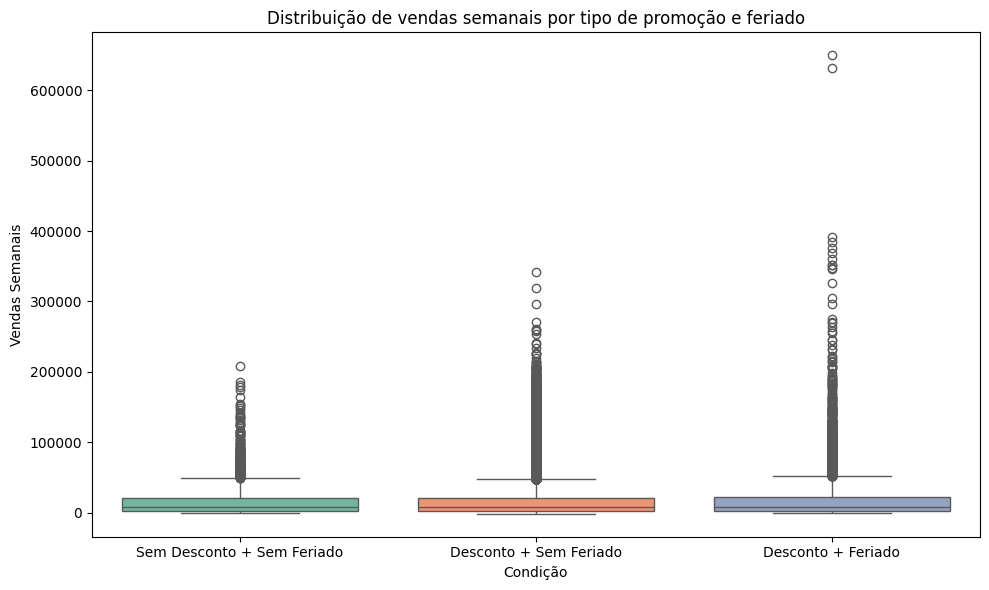

In [216]:
df['Has_Discount'] = df[markdown_cols].sum(axis=1) > 0

# Criar grupos de comparação
def classify_group(row):
    if row['Has_Discount'] and row['IsHoliday']:
        return 'Desconto + Feriado'
    elif row['Has_Discount'] and not row['IsHoliday']:
        return 'Desconto + Sem Feriado'
    elif not row['Has_Discount'] and row['IsHoliday']:
        return 'Sem Desconto + Feriado'
    else:
        return 'Sem Desconto + Sem Feriado'

df['Grupo'] = df.apply(classify_group, axis=1)

# Plotar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Grupo', y='Weekly_Sales', palette='Set2')
plt.title('Distribuição de vendas semanais por tipo de promoção e feriado')
plt.ylabel('Vendas Semanais')
plt.xlabel('Condição')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [217]:
df.groupby("Grupo")["Weekly_Sales"].sum() / df["Weekly_Sales"].sum()

Grupo
Desconto + Feriado            0.084445
Desconto + Sem Feriado        0.896080
Sem Desconto + Sem Feriado    0.019475
Name: Weekly_Sales, dtype: float64

<Axes: xlabel='Grupo'>

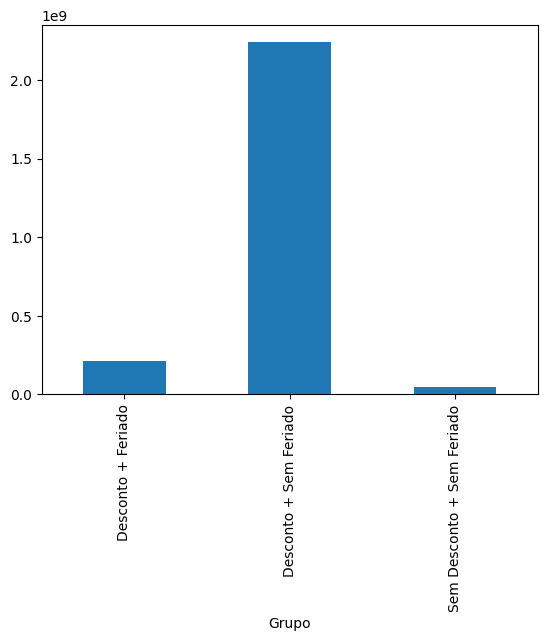

In [255]:
df.groupby("Grupo")["Weekly_Sales"].sum().plot(kind='bar')

In [222]:

# Calcular Q1, Q3 e IQR
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Limite superior para outliers
upper_bound = Q3 + 1.5 * IQR

# Filtrar vendas acima do limite
outlier_sales = df[df['Weekly_Sales'] > upper_bound]
outlier_sales

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,DayOfYear,DescontoSum,TemDesconto,DescontoAvg,Dept_encoded,Store_encoded,Type_encoded,Month_encoded,Has_Discount,Grupo
106,106,1,1,2012-02-17,54060.10,False,45.32,3.510,9873.33,11062.27,...,48,32757.37,True,6551.474,19213.485088,21710.543621,20099.568043,16008.779217,True,Desconto + Sem Feriado
113,113,1,1,2012-04-06,57592.12,False,70.43,3.891,10121.97,0.00,...,97,18461.26,True,3692.252,19213.485088,21710.543621,20099.568043,15650.338357,True,Desconto + Sem Feriado
239,239,1,2,2011-12-09,49357.43,False,43.93,3.158,4640.65,19.00,...,343,22865.91,True,4573.182,43607.020113,21710.543621,20099.568043,19355.702141,True,Desconto + Sem Feriado
240,240,1,2,2011-12-16,51137.42,False,51.63,3.159,5011.32,67.00,...,350,9662.85,True,1932.570,43607.020113,21710.543621,20099.568043,19355.702141,True,Desconto + Sem Feriado
241,241,1,2,2011-12-23,65615.36,False,47.96,3.112,2725.36,40.48,...,357,6164.87,True,1232.974,43607.020113,21710.543621,20099.568043,19355.702141,True,Desconto + Sem Feriado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421285,421285,45,95,2012-09-28,49380.11,False,64.88,3.997,4556.61,20.64,...,272,9468.01,True,1893.602,69824.423080,11662.897315,12237.075977,15095.886154,True,Desconto + Sem Feriado
421286,421286,45,95,2012-10-05,50241.01,False,64.89,3.985,5046.74,0.00,...,279,9659.00,True,1931.800,69824.423080,11662.897315,12237.075977,15243.855576,True,Desconto + Sem Feriado
421287,421287,45,95,2012-10-12,49334.77,False,54.47,4.000,1956.28,0.00,...,286,6554.03,True,1310.806,69824.423080,11662.897315,12237.075977,15243.855576,True,Desconto + Sem Feriado
421288,421288,45,95,2012-10-19,48434.97,False,56.47,3.969,2004.02,0.00,...,293,3982.42,True,796.484,69824.423080,11662.897315,12237.075977,15243.855576,True,Desconto + Sem Feriado


<Axes: xlabel='Grupo'>

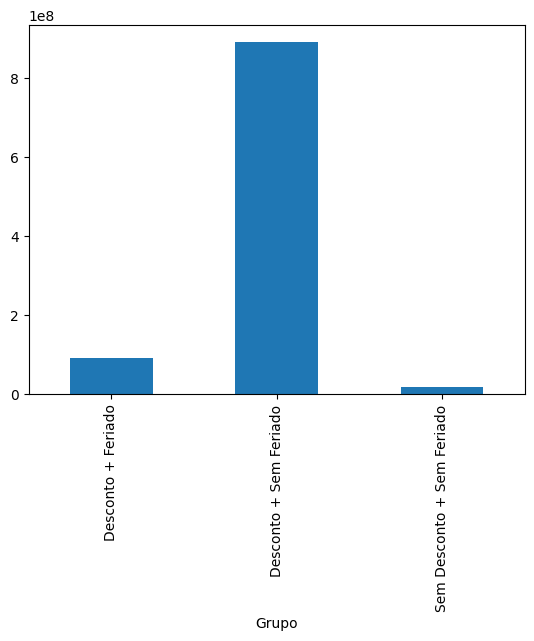

In [254]:
outlier_sales.groupby("Grupo")["Weekly_Sales"].sum().plot(kind='bar')

### 3.4 Análise efeitos dos descontos durante as semanas festivas

Serão geradas variaveis de interação entre IsHoliday e cada Markdown. Uma variável de interação é o produto de duas variáveis e serve para modelar o efeito combinado delas sobre o alvo.
Com as variáveis IsHoliday, Markdowns e suas interações será treinado um modelo simples de regressão linear para tentar analisar o impacto das variáveis no target, Weekly_Sales

Exemplo de variável de interação:

variavel_interacao = Markdown1 * IsHoliday

- Quando IsHoliday = 0, a variável de interação será 0, ou seja, sem efeito de feriado.
- Quando IsHoliday = 1, a variável de interação será igual ao valor do desconto, indicando que o efeito está "ligado".

In [261]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

df['IsHoliday'] = df['IsHoliday'].astype(int)

# Criando interações: promoção * feriado
for col in markdown_cols:
    df[f'{col}_holiday'] = df[col] * df['IsHoliday']

features = markdown_cols + ['IsHoliday'] + [f'{col}_holiday' for col in markdown_cols]
X = df[features]
y = df['Weekly_Sales']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     294.7
Date:                Thu, 05 Jun 2025   Prob (F-statistic):               0.00
Time:                        23:32:54   Log-Likelihood:            -1.7695e+06
No. Observations:              154386   AIC:                         3.539e+06
Df Residuals:                  154374   BIC:                         3.539e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.292e+04     92.492    139.731      0.000    1.27e+04    1.31e+04
MarkDown1             0.2913      0.013     22.208      0.000       0.266       0.317
MarkDown2             0.0956      0.013      7.423      0.000       0.070       0.121
MarkDown3             0.7302      0.061     11.922      0.000       0.610       0.850
MarkDown4            -0.1402      0.018     -7.783      0.000      -0.176      -0.105
MarkDown5             0.2575      0.011     24.509      0.000       0.237       0.278
IsHoliday         -5751.3785    459.611    -12.514      0.000   -6652.206   -4850.551
MarkDown1_holiday     0.0299      0.054      0.552      0.581      -0.076       0.136
MarkDown2_holiday     0.0182      0.016      1.118      0.264      -0.014       0.050
MarkDown3_holiday    -0.5027      0.062     -8.135      0.000      -0.624      -0.382
MarkDown4_holiday     0.1064      0.068      1.561      0.118      -0.027       0.240
MarkDown5_holiday     0.8530      0.112      7.602      0.000       0.633       1.073
==============================================================================
Omnibus:                   112887.074   Durbin-Watson:                   0.155
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3130634.530
Skew:                           3.235   Prob(JB):                         0.00
Kurtosis:                      24.091   Cond. No.                     1.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [288]:
results_df = pd.DataFrame({
    'coef': model.params,
    'std_err': model.bse,
    't': model.tvalues,
    'P>|t|': model.pvalues,
    'conf_lower': model.conf_int()[0],
    'conf_upper': model.conf_int()[1]
})

In [326]:
results_df.coef.sort_values(ascending=False).to_frame()

,coef
const,12923.931886
MarkDown5_holiday,0.852958
MarkDown3,0.730171
MarkDown1,0.291273
MarkDown5,0.257454
MarkDown4_holiday,0.106364
MarkDown2,0.095563
MarkDown1_holiday,0.029871
MarkDown2_holiday,0.018178
MarkDown4,-0.140205


<Figure size 1200x800 with 0 Axes>

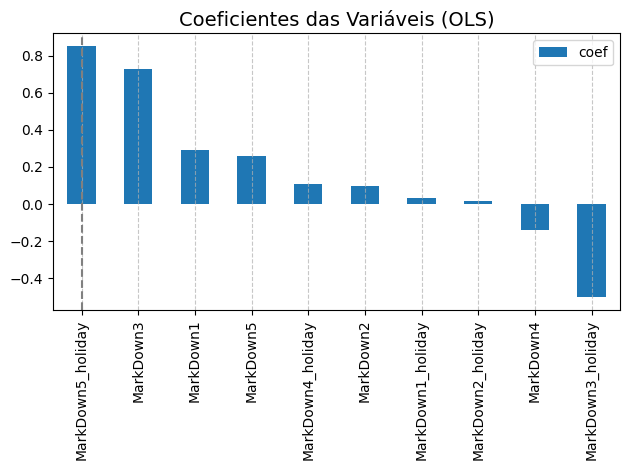

In [328]:
plt.figure(figsize=(12, 8))

results_df.coef.sort_values(ascending=False).to_frame().T.drop(columns=["const", "IsHoliday"]).T.plot(kind="bar")

plt.axvline(0, color='gray', linestyle='--')
plt.title("Coeficientes das Variáveis (OLS)", fontsize=14)
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

- O modelo explica apenas 2,1% da variabilidade das vendas semanais. Isso é muito baixo, indicando que os descontos e feriados capturam apenas uma pequena parte do que afeta as vendas. Como visto anteriormente no treinamento do modelo preditivo, eles tem importancia baixa no modelo.

Com relação a descontos:

- MarkDown3 é um desconto que impacta muito durante o ano todo, cerca de 73%, e perde força em feriados, cerca de 50%.
- MarkDown5 tem o maior ganho durante semanas de feriado, cerca de 85%: estratégia de promoção forte.